In [1]:
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import utils
import torchvision

from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/논문/'

In [3]:
# trainset = datasets.STL10(root= path + 'data',split = 'train',download=True,transform=T.ToTensor())
trainset = datasets.CIFAR10(root= path + 'data',train=True,download=True,transform=T.ToTensor())
trainset, valset = torch.utils.data.random_split(trainset, [int(len(trainset)*0.8), int(len(trainset)*0.2)])
# testset = datasets.STL10(root = path+ ' data',split = 'test',download=True,transform = T.ToTensor())
testset = datasets.CIFAR10(root = path+ ' data',train=False,download=True,transform = T.ToTensor())
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
img,label = trainset[0]
print(img.shape)

torch.Size([3, 32, 32])


In [5]:
print(len(trainset))
print(len(testset))

40000
10000


In [6]:
## Normalization
train_meanRGB = [np.mean(x.numpy(),axis = (1,2)) for x,_ in trainset] # 채널별 평균
train_stdRGB = [np.std(x.numpy(),axis = (1,2)) for x,_ in trainset] # 채널별 std

train_meanR = np.mean([m[0] for m in train_meanRGB]) 
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([m[0] for m in train_stdRGB])
train_stdG = np.mean([m[1] for m in train_stdRGB])
train_stdB = np.mean([m[2] for m in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(),axis=(1,2)) for x,_ in valset]
val_stdRGB = [np.std(x.numpy(),axis=(1,2)) for x,_ in valset]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(f'train RGB : {train_meanR} {train_meanG} {train_meanB}')
print(f'val RGB : {val_meanR} {val_meanG} {val_meanB}')

train RGB : 0.4909271001815796 0.48175927996635437 0.44631046056747437
val RGB : 0.4932900369167328 0.4837550222873688 0.4474126994609833


In [7]:
train_transform = T.Compose([
                            #  T.Resize(256),
                            #  T.Lambda(lambda crops : torch.stack([T.ToTensor()(crop) for crop in crops])),
                             T.Normalize([train_meanR,train_meanG,train_meanB],[train_stdR,train_stdG,train_stdB])
])
trainset.transform = train_transform
valset.transform = train_transform

In [8]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size,shuffle = True)
valloader = torch.utils.data.DataLoader(valset,batch_size = batch_size,shuffle = True)
testloader = torch.utils.data.DataLoader(testset,batch_size = batch_size)

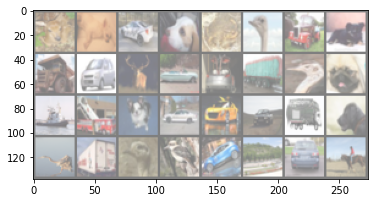

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print(classes[labels])

In [10]:
# int = output channel 개수
# M = max pooling layer

cfgs = {'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']}

In [11]:
# define VGGnet class
class VGG(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super().__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(cfgs[model])

        self.fcs = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        x = x.view(x.size(0),-1)

        # print(x.shape)
        x = self.fcs(x)
        return x

    # defint weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    # define a function to create conv layer taken the key of VGG_type dict 
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        
        return nn.Sequential(*layers)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
model = VGG('VGG16',in_channels=3,num_classes = 10,init_weights=True).to(device)
model = model.to(device)
print(model)

VGG(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), str

In [14]:
summary(model,input_size = (3,32,32),device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [15]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 10,gamma=0.1)
model = model.to(device)
print(device)

cuda


In [25]:
total_step = len(trainloader)
epoch = 20
best_val_acc = 0
loss_list = []
train_plt_list = []
for e in tqdm(range(epoch)):
    train_acc_list = []
    running_loss = 0

    model.train()
    for i,(images,labels) in tqdm(enumerate(trainloader)):
        images = images*0.99 + 1e-3
        images = images.type(torch.FloatTensor).to(device)
        labels = labels.to(device,dtype=torch.int64)

        optimizer.zero_grad()

        probs = model(images)
        loss = loss_func(probs,labels)

        loss.backward()
        
        
        optimizer.step()

        running_loss += loss.item()

        # print(probs)
        preds = torch.argmax(probs,1)
        preds = preds.cpu().detach().numpy()
        # probs = probs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        
        # print('pred',pred)
        
        batch_acc = (labels == preds).mean()
        train_acc_list.append(batch_acc)
    loss_list.append(running_loss/total_step)
    train_acc = np.mean(train_acc_list)
    train_plt_list.append(train_acc)
    print(f'Epochs : {e+1}/{epoch}, loss : {running_loss/total_step}, Train accuracy : {train_acc}')

    model.eval()
    val_acc_list = []
    val_plt_list = []
    with torch.no_grad():
        correct = 0
        total = 0

        for images,labels in valloader:
            images = images*0.99 + 1e-3
            images = images.type(torch.FloatTensor).to(device)
            labels = labels.to(device,dtype = torch.int64)
            probs = model(images)
            loss = loss_func(probs,labels)
            preds = torch.argmax(probs,1)
            preds = preds.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            batch_acc = (labels == preds).mean()
            val_acc_list.append(batch_acc)
        val_acc = np.mean(val_acc_list)
        val_plt_list.append(val_acc)
        print(f'validation acc : {val_acc}')
    scheduler.step()

0it [00:00, ?it/s]

loss : 2.766480912208557, Train accuracy : 0.1421
validation acc : 0.17861421725239618


0it [00:00, ?it/s]

loss : 2.0091924865722657, Train accuracy : 0.200525
validation acc : 0.2527955271565495


0it [00:00, ?it/s]

loss : 1.8658970748901367, Train accuracy : 0.257475
validation acc : 0.22543929712460065


0it [00:00, ?it/s]

loss : 1.6966871953964233, Train accuracy : 0.327875
validation acc : 0.34474840255591055


0it [00:00, ?it/s]

loss : 1.5788257395744323, Train accuracy : 0.389375
validation acc : 0.3777955271565495


0it [00:00, ?it/s]

loss : 1.4585738837718965, Train accuracy : 0.44855
validation acc : 0.5098841853035144


0it [00:00, ?it/s]

loss : 1.2957032131195068, Train accuracy : 0.527575
validation acc : 0.5861621405750799


0it [00:00, ?it/s]

loss : 1.1376832527637482, Train accuracy : 0.60195
validation acc : 0.6258985623003195


0it [00:00, ?it/s]

loss : 1.005491007375717, Train accuracy : 0.6557
validation acc : 0.6621405750798722


0it [00:00, ?it/s]

loss : 0.8794902616024017, Train accuracy : 0.704775
validation acc : 0.7293330670926518


0it [00:00, ?it/s]

loss : 0.6120946723341942, Train accuracy : 0.7954
validation acc : 0.7820487220447284


0it [00:00, ?it/s]

loss : 0.5472926864266395, Train accuracy : 0.815425
validation acc : 0.7889376996805112


0it [00:00, ?it/s]

loss : 0.5042569598197937, Train accuracy : 0.831725
validation acc : 0.7962260383386581


0it [00:00, ?it/s]

loss : 0.46960752783417703, Train accuracy : 0.84235
validation acc : 0.803214856230032


0it [00:00, ?it/s]

loss : 0.43191439561247824, Train accuracy : 0.855975
validation acc : 0.8021166134185304


0it [00:00, ?it/s]

loss : 0.3977507473826408, Train accuracy : 0.866775
validation acc : 0.8065095846645367


0it [00:00, ?it/s]

loss : 0.36401057474017146, Train accuracy : 0.87845
validation acc : 0.8035143769968051


0it [00:00, ?it/s]

loss : 0.33180225623846055, Train accuracy : 0.888525
validation acc : 0.8061102236421726


0it [00:00, ?it/s]

loss : 0.2961148730173707, Train accuracy : 0.902275
validation acc : 0.8122004792332268


0it [00:00, ?it/s]

loss : 0.26827598384171725, Train accuracy : 0.9117
validation acc : 0.8065095846645367


0it [00:00, ?it/s]

loss : 0.21410444647222757, Train accuracy : 0.92935
validation acc : 0.8138977635782748


0it [00:00, ?it/s]

loss : 0.20146023353114725, Train accuracy : 0.93325
validation acc : 0.814297124600639


0it [00:00, ?it/s]

loss : 0.19107271409779786, Train accuracy : 0.938925
validation acc : 0.81439696485623


0it [00:00, ?it/s]

loss : 0.18661295693032443, Train accuracy : 0.9397
validation acc : 0.8145966453674122


0it [00:00, ?it/s]

loss : 0.18141972705349327, Train accuracy : 0.94035
validation acc : 0.8144968051118211


0it [00:00, ?it/s]

loss : 0.1760890451051295, Train accuracy : 0.9429
validation acc : 0.8131988817891374


0it [00:00, ?it/s]

loss : 0.17251365677118302, Train accuracy : 0.943725
validation acc : 0.8130990415335463


0it [00:00, ?it/s]

loss : 0.1681863149575889, Train accuracy : 0.946075
validation acc : 0.8136980830670927


0it [00:00, ?it/s]

loss : 0.1664139104858041, Train accuracy : 0.94615
validation acc : 0.8120007987220448


0it [00:00, ?it/s]

loss : 0.16087267921566964, Train accuracy : 0.947175
validation acc : 0.8126996805111821


0it [00:00, ?it/s]

loss : 0.15213149064630271, Train accuracy : 0.951175
validation acc : 0.8125998402555911


0it [00:00, ?it/s]

loss : 0.15060769880153238, Train accuracy : 0.952075
validation acc : 0.8124001597444089


0it [00:00, ?it/s]

loss : 0.15102643868997692, Train accuracy : 0.9513
validation acc : 0.8110023961661342


0it [00:00, ?it/s]

loss : 0.14924809719361365, Train accuracy : 0.95145
validation acc : 0.8118011182108626


0it [00:00, ?it/s]

loss : 0.1487790566906333, Train accuracy : 0.95305
validation acc : 0.8125998402555911


0it [00:00, ?it/s]

loss : 0.14911820645593107, Train accuracy : 0.953175
validation acc : 0.8122004792332268


0it [00:00, ?it/s]

loss : 0.1488333759225905, Train accuracy : 0.951125
validation acc : 0.8110023961661342


0it [00:00, ?it/s]

loss : 0.14979761596471072, Train accuracy : 0.952825
validation acc : 0.8133985623003195


0it [00:00, ?it/s]

loss : 0.14474559486955405, Train accuracy : 0.9524
validation acc : 0.8131988817891374


0it [00:00, ?it/s]

loss : 0.14889236068949102, Train accuracy : 0.9519
validation acc : 0.8114017571884984


0it [00:00, ?it/s]

loss : 0.14818835687935353, Train accuracy : 0.9523
validation acc : 0.8125998402555911


0it [00:00, ?it/s]

loss : 0.1458992725893855, Train accuracy : 0.953
validation acc : 0.8122004792332268


0it [00:00, ?it/s]

loss : 0.14586248656362294, Train accuracy : 0.953525
validation acc : 0.8128993610223643


0it [00:00, ?it/s]

loss : 0.14684654334634542, Train accuracy : 0.95295
validation acc : 0.8121006389776357


0it [00:00, ?it/s]

loss : 0.14638775480110197, Train accuracy : 0.9523
validation acc : 0.8115015974440895


0it [00:00, ?it/s]

loss : 0.14836478365957737, Train accuracy : 0.9529
validation acc : 0.8125


0it [00:00, ?it/s]

loss : 0.14526380343288184, Train accuracy : 0.9548
validation acc : 0.8109025559105432


0it [00:00, ?it/s]

loss : 0.14598562048710884, Train accuracy : 0.9523
validation acc : 0.8139976038338658


0it [00:00, ?it/s]

loss : 0.14779602892324328, Train accuracy : 0.952775
validation acc : 0.8113019169329073


0it [00:00, ?it/s]

loss : 0.14553534211292862, Train accuracy : 0.9529
validation acc : 0.8114017571884984


0it [00:00, ?it/s]

loss : 0.14666735642030834, Train accuracy : 0.952975
validation acc : 0.8128993610223643


0it [00:00, ?it/s]

loss : 0.14871659729331732, Train accuracy : 0.952175
validation acc : 0.8105031948881789


0it [00:00, ?it/s]

loss : 0.14658613747656346, Train accuracy : 0.9527
validation acc : 0.8115015974440895


0it [00:00, ?it/s]

loss : 0.14633427645340563, Train accuracy : 0.95375
validation acc : 0.8126996805111821


0it [00:00, ?it/s]

loss : 0.14469853856042028, Train accuracy : 0.95305
validation acc : 0.8120007987220448


0it [00:00, ?it/s]

loss : 0.14866227380260824, Train accuracy : 0.951875
validation acc : 0.8116014376996805


0it [00:00, ?it/s]

loss : 0.14693137024976313, Train accuracy : 0.9525
validation acc : 0.8127995207667732


0it [00:00, ?it/s]

loss : 0.14797907200157642, Train accuracy : 0.95275
validation acc : 0.8122004792332268


0it [00:00, ?it/s]

loss : 0.14900256137810647, Train accuracy : 0.95245
validation acc : 0.8122004792332268


0it [00:00, ?it/s]

loss : 0.1457559074357152, Train accuracy : 0.9531
validation acc : 0.8114017571884984


0it [00:00, ?it/s]

loss : 0.14881486356556414, Train accuracy : 0.9519
validation acc : 0.8116014376996805


0it [00:00, ?it/s]

loss : 0.14580458762980997, Train accuracy : 0.95335
validation acc : 0.8119009584664537


0it [00:00, ?it/s]

loss : 0.15030475414022804, Train accuracy : 0.951875
validation acc : 0.8119009584664537


0it [00:00, ?it/s]

loss : 0.14724023908041417, Train accuracy : 0.951925
validation acc : 0.8119009584664537


0it [00:00, ?it/s]

loss : 0.1452205163836479, Train accuracy : 0.95295
validation acc : 0.8124001597444089


0it [00:00, ?it/s]

loss : 0.14647762465700506, Train accuracy : 0.952975
validation acc : 0.8118011182108626


0it [00:00, ?it/s]

loss : 0.14630524264276026, Train accuracy : 0.953425
validation acc : 0.8129992012779552


0it [00:00, ?it/s]

loss : 0.14535108506120742, Train accuracy : 0.9528
validation acc : 0.8134984025559105


0it [00:00, ?it/s]

loss : 0.14711047663874924, Train accuracy : 0.952875
validation acc : 0.8126996805111821


0it [00:00, ?it/s]

loss : 0.14738271884061396, Train accuracy : 0.952
validation acc : 0.810702875399361


0it [00:00, ?it/s]

loss : 0.14544526589363813, Train accuracy : 0.9539
validation acc : 0.8120007987220448


0it [00:00, ?it/s]

loss : 0.14733989359289407, Train accuracy : 0.952175
validation acc : 0.8129992012779552


0it [00:00, ?it/s]

loss : 0.14599117243662477, Train accuracy : 0.95375
validation acc : 0.8124001597444089


0it [00:00, ?it/s]

loss : 0.14794086147919297, Train accuracy : 0.951375
validation acc : 0.8109025559105432


0it [00:00, ?it/s]

loss : 0.14637852466478943, Train accuracy : 0.9538
validation acc : 0.8121006389776357


0it [00:00, ?it/s]

loss : 0.14636333367303014, Train accuracy : 0.952725
validation acc : 0.8138977635782748


0it [00:00, ?it/s]

loss : 0.14546660598888994, Train accuracy : 0.953325
validation acc : 0.8108027156549521


0it [00:00, ?it/s]

loss : 0.14494995106756686, Train accuracy : 0.95345
validation acc : 0.8131988817891374


0it [00:00, ?it/s]

loss : 0.14653956632688642, Train accuracy : 0.95315
validation acc : 0.8111022364217252


0it [00:00, ?it/s]

loss : 0.14723843639865516, Train accuracy : 0.952275
validation acc : 0.8122004792332268


0it [00:00, ?it/s]

loss : 0.14807874532416462, Train accuracy : 0.952825
validation acc : 0.8123003194888179


0it [00:00, ?it/s]

loss : 0.1482289874777198, Train accuracy : 0.952025
validation acc : 0.8111022364217252


0it [00:00, ?it/s]

loss : 0.1459894425600767, Train accuracy : 0.952825
validation acc : 0.8126996805111821


0it [00:00, ?it/s]

loss : 0.14638055558502674, Train accuracy : 0.952375
validation acc : 0.8130990415335463


0it [00:00, ?it/s]

loss : 0.14708961039111018, Train accuracy : 0.95185
validation acc : 0.8121006389776357


0it [00:00, ?it/s]

loss : 0.1474760419383645, Train accuracy : 0.953
validation acc : 0.8130990415335463


0it [00:00, ?it/s]

loss : 0.1467041652970016, Train accuracy : 0.952825
validation acc : 0.8110023961661342


0it [00:00, ?it/s]

loss : 0.14569760205745697, Train accuracy : 0.95325
validation acc : 0.8119009584664537


0it [00:00, ?it/s]

loss : 0.14738909972198308, Train accuracy : 0.953175
validation acc : 0.8125998402555911


0it [00:00, ?it/s]

loss : 0.14574002565070987, Train accuracy : 0.952825
validation acc : 0.8124001597444089


0it [00:00, ?it/s]

loss : 0.14536980584003031, Train accuracy : 0.953125
validation acc : 0.8128993610223643


0it [00:00, ?it/s]

loss : 0.14782685096301137, Train accuracy : 0.952625
validation acc : 0.8132987220447284


0it [00:00, ?it/s]

loss : 0.14520674919486046, Train accuracy : 0.953125
validation acc : 0.8125


0it [00:00, ?it/s]

loss : 0.14707085621878505, Train accuracy : 0.95355
validation acc : 0.8126996805111821


0it [00:00, ?it/s]

loss : 0.14593893106356262, Train accuracy : 0.9531
validation acc : 0.8119009584664537


0it [00:00, ?it/s]

loss : 0.14563957249708473, Train accuracy : 0.953
validation acc : 0.8117012779552716


0it [00:00, ?it/s]

loss : 0.14860132058374584, Train accuracy : 0.952
validation acc : 0.8127995207667732


0it [00:00, ?it/s]

loss : 0.14756028439328076, Train accuracy : 0.9513
validation acc : 0.8111022364217252


0it [00:00, ?it/s]

loss : 0.148831478946656, Train accuracy : 0.951375
validation acc : 0.8118011182108626


0it [00:00, ?it/s]

loss : 0.1473826703749597, Train accuracy : 0.95215
validation acc : 0.8124001597444089


Text(0.5, 1.0, 'Loss')

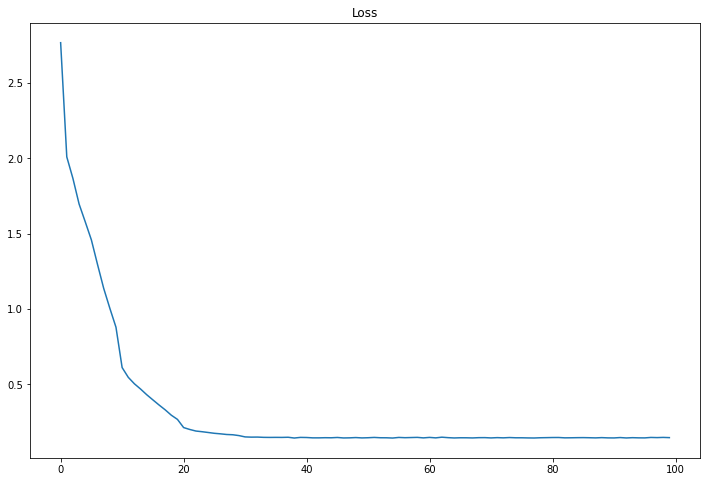

In [26]:
plt.figure(figsize = (12,8))
plt.plot(loss_list)
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

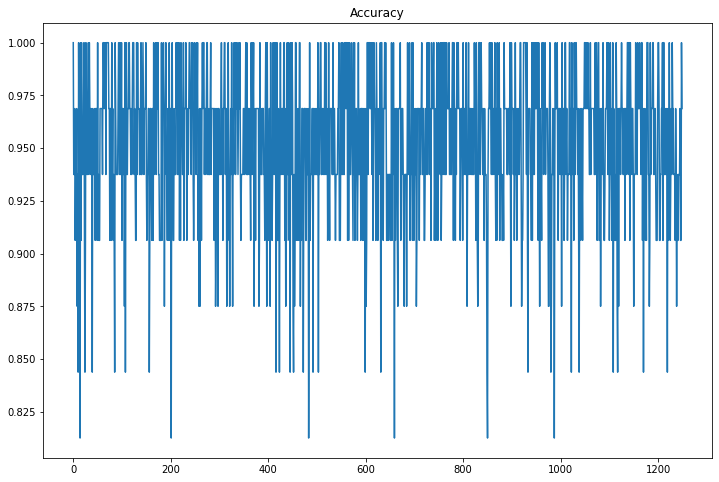

In [29]:
plt.figure(figsize=(12,8))
plt.plot(train_acc_list)
plt.title('Accuracy')